In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import random


class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = rank
        # noinspection PyUnusedLocal
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]


class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    # noinspection PyProtectedMember
    def solve(self, graph: Graph):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        for gen in range(self.generations):
            # noinspection PyUnusedLocal
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            # print('generation #{}, best cost: {}, path: {}'.format(gen, best_cost, best_solution))
        return best_solution, best_cost


class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  # the local increase of pheromone
        self.allowed = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  # heuristic information
        start = 4  # Rubah disini titik awalnya
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][
                                                                                            i] ** self.colony.beta
        # noinspection PyUnusedLocal
        probabilities = [0 for i in range(self.graph.rank)]  # probabilities for moving to a node in the next step
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [4]:
import operator

import matplotlib.pyplot as plt


def plot(points, path: list):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    # noinspection PyUnusedLocal
    y = list(map(operator.sub, [max(y) for i in range(len(points))], y))
    plt.plot(x, y, 'co')

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]
        # noinspection PyUnresolvedReferences
        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r', length_includes_head=True)

    # noinspection PyTypeChecker
    plt.xlim(0, max(x) * 1.1)
    # noinspection PyTypeChecker
    plt.ylim(0, max(y) * 1.1)
    plt.show()

cost: 125.53698814408818, path: [4, 6, 8, 9, 7, 5, 3, 2, 1, 0]
Waktu tempuh: 2.092283135734803


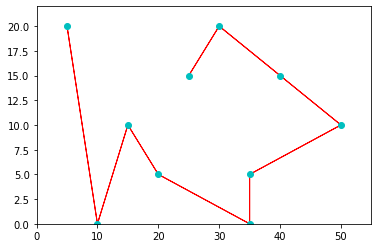

[{'index': 1, 'x': 5, 'y': 5}, {'index': 2, 'x': 10, 'y': 25}, {'index': 3, 'x': 15, 'y': 15}, {'index': 4, 'x': 20, 'y': 20}, {'index': 5, 'x': 25, 'y': 10}, {'index': 6, 'x': 35, 'y': 25}, {'index': 7, 'x': 30, 'y': 5}, {'index': 8, 'x': 35, 'y': 20}, {'index': 9, 'x': 40, 'y': 10}, {'index': 0, 'x': 50, 'y': 15}]


In [5]:
import math

def distance(city1: dict, city2: dict):
    return math.sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)


def main():
    cities = []
    points = []
    with open('./chn31.txt') as f:
        for line in f.readlines():
            city = line.split(' ')
            cities.append(dict(index=int(city[0]), x=int(city[1]), y=int(city[2])))
            points.append((int(city[1]), int(city[2])))
    cost_matrix = []
    rank = len(cities)
    for i in range(rank):
        row = []
        for j in range(rank):
            row.append(distance(cities[i], cities[j]))
        cost_matrix.append(row)
    aco = ACO(10, 100, 1.0, 10.0, 0.5, 10, 2)
    graph = Graph(cost_matrix, rank)
    path, cost = aco.solve(graph)
    print('cost: {}, path: {}'.format(cost, path))
    time = cost/60
    print('Waktu tempuh: {}'.format(time))
    plot(points, path)
    print(cities)

if __name__ == '__main__':
    main()